In [32]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import statistics
import pandas as pd
import matplotlib.patches as mpatches
from scipy import stats
%matplotlib inline

In [33]:
## basic read in

In [34]:
def max_acc_point(acc_list):
    acc_point = np.argmax(acc_list)
    return acc_point

In [35]:
def min_loss_point(loss_list):
    loss_point = np.argmin(loss_list)
    return loss_point

In [36]:
def index_less_than(mylist,myvalue,value2):
    for i in range(len(mylist)):
        if mylist[i]<myvalue:
            if mylist[i]>0.78:
                return len(mylist)-1
            else:
                return i
#             if mylist[i]<value2:
#                        return i
    return len(mylist)-1

In [37]:
def es_point(acc_list,p): # p means steps after the max index
    max_num = 0
    count = 0
    for i in range(len(acc_list)):
        if acc_list[i]>max_num:
            max_num = acc_list[i]
            count = 0
        count = count+1
        if count>p:
            return i-1
    return int(len(acc_list)-1)

In [38]:
def windowed(s,half_window): # s is a list
    s_mean=[]
    s_var=[]
    window_size = half_window*2 + 1
    for i in range(len(s)-window_size+1):
        k = i + half_window 
        s_sub=s[k-half_window:k+half_window+1]
        sub_mean=sum(s_sub)/len(s_sub)
        s_mean.append(sub_mean)
        sub_var=statistics.variance(s_sub)
        s_var.append(sub_var)
    return s_mean,s_var

In [39]:
def read_acc_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['acc'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1).dropna()
    if speed==1:
        return normalset_mean   
    delayset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    delayset_mean = delayset.mean(axis=1).dropna()
    return normalset_mean,delayset_mean
def read_loss_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['loss'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1).dropna()
    if speed==1:
        return normalset_mean   
    delayset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    delayset_mean = delayset.mean(axis=1).dropna()
    return normalset_mean,delayset_mean

In [40]:
## how to plot

In [41]:
def plot_line(i,k,basedir,result,lab,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=1000
    s1_epo = [i+1 for i in s1[0][:p]]
    ax[i].plot(s1_epo,s1[2][:p], label=lab[k]+addon)

In [42]:
def plot_window_acc(i,k,half_window,basedir,result,lab,line_color,dot_color,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=1000
    
    (s_mean,s_varience)=windowed(s1[2][:p],half_window)

    s_epo=[i+half_window+1 for i in range(len(s_mean))]
    ax[i].plot(s_epo,s_mean, label=lab[k]+addon,color = line_color) # can also plot s_varience if want
    
    (s_loss,_)=windowed(s1[1][:p],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    ax[i].plot(index_min_loss+half_window+1,s_mean[index_min_loss],dot_color)

#     index_max=np.argmax(s_mean)
#     ax[i].plot(index_max+half_window+1,s_mean[index_max],dot_color)


In [43]:
def plot_file_acc(i,k,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k]
    if speed==1:
        normalset_mean = read_acc_mean(files,i,speed)
        set_plt = [i+1 for i in range(len(normalset_mean))]
        ax[i].plot(set_plt,normalset_mean, label=linelab+'_t')
#         print('only usual')
        
    else:
        normalset_mean,delayset_mean = read_acc_mean(files,i,speed)
        
        normal_plt = [i+1 for i in range(len(normalset_mean))]
        ax[i].plot(normal_plt,normalset_mean, label=linelab+'_usual')
        
        new_delay_set = [val for val in delayset_mean for _ in range(speed)]
        delay_plt = [i+1 for i in range(len(new_delay_set))]
        ax[i].plot(delay_plt,new_delay_set, label=linelab+'_delay')

In [44]:
def plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k]
    if speed==1:
        normalset_mean = read_acc_mean(files,i,speed)
        (s_mean,s_varience)=windowed(normalset_mean,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_t')
    else:
        normalset_mean,delayset_mean = read_acc_mean(files,i,speed)

        (s_mean,s_varience)=windowed(normalset_mean,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_usual')
        
        new_delay_set = [val for val in delayset_mean for _ in range(speed)]
        (s_mean,s_varience)=windowed(new_delay_set,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_delay')


## Bad Node

In [26]:
half_window = 10
th = 0.025
value2 = 1

index_min_loss_list = []
index_min_acc_list = []
min_loss_list = []
min_acc_list = []
acc_at_min_loss_list = []
index_less_than_nb_list = []
gap_to_min_list = []
acc_drop_list = []


basedir=os.path.join('RESULT_4000/BadNode')

color_list=[
#     'k',
    'r','c',
#     'k',
    'r','c',
#     'k',
    'r','c',
    
#     'k',
    'r','b','c',
#     'k',
#     'r','b','c',
#     'k',
    'r','b','c',
#     'k',
    'r','b','c',
    
]

size_list = [
    1,1,1,1,1,1,
    2,2,2,2,2,2,2,2,2,
]
iid_list = [
    1,1,2,2,3,3,
    1,1,1,2,2,2,3,3,3,
]


result=[
#     '2c.10w.4000.loc1.earlystop500.20200501-072809.npy',
    '2c.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-015142.npy',
    '2c.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-031558.npy',

#     '5c.10w.4000.loc1.earlystop500.20200501-024326.npy',
    '5c.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-023155.npy',
    '5c.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-004052.npy',

#     'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',
    '11d.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-020918.npy',
    '11d.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-060927.npy',
]

for res in result:
    s1 = np.load(os.path.join(basedir,res))
    (s_acc,_)=windowed(s1[2][:1000],half_window)
    (s_loss,_)=windowed(s1[1][:1000],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    index_min_acc = min_loss_point(s_acc[index_min_loss:])+index_min_loss
    
    
    min_loss = s_loss[index_min_loss]
    min_acc = s_acc[index_min_acc]
    
    acc_at_min_loss = s_acc[index_min_loss]
    index_less_than_nb = index_less_than(s_acc[index_min_loss:],min_acc+th,value2)+index_min_loss #index of acc drop to min_acc+some range
    gap_to_min = index_less_than(s_acc[index_min_loss:],min_acc+th,value2) #gap between cropped & min_loss
    
    acc_drop = s_acc[index_less_than_nb]
    
    
    index_min_loss_list.append(index_min_loss)
    index_min_acc_list.append(index_min_acc)
    min_loss_list.append(min_loss)
    min_acc_list.append(min_acc)
    acc_at_min_loss_list.append(acc_at_min_loss) # Try with it's original&iid min_at_loss???
    index_less_than_nb_list.append(index_less_than_nb) # 
    gap_to_min_list.append(gap_to_min)
    acc_drop_list.append(acc_drop)
    
basedir=os.path.join('RESULT_40000/BadNode')    
result=[
#     '2c.10w.40000.loc1.earlystop1000.20200521-163612.npy',
    '2c.10w.40000.plus1bad_each400.loc1.earlystop1000.20200521-150153.npy',
    '2c.10w.40000.plus1bad_each1200.loc1.earlystop1000.20200523-055725.npy',
    '2c.10w.40000.plus1bad_each4000.loc1.earlystop1000.20200521-152141.npy',
    
# #     '3c.10w.40000.loc1.earlystop1000.20200523-042344.npy',
#     '3c.10w.40000.plus1bad_each400.loc1.earlystop1000.20200523-043427.npy',
#     '3c.10w.40000.plus1bad_each1200.loc1.earlystop1000.20200523-054717.npy',
#     '3c.10w.40000.plus1bad_each4000.loc1.earlystop1000.20200523-043024.npy',
    
#     '5c.10w.40000.loc1.earlystop1000.20200521-171047.npy',
    '5c.10w.40000.plus1bad_each400.loc1.earlystop1000.20200521-152400.npy',
    '5c.10w.40000.plus1bad_each1200.loc1.earlystop1000.20200523-055914.npy',
    '5c.10w.40000.plus1bad_each4000.loc1.earlystop1000.20200521-165039.npy',
    
#     'iid.10w.40000.loc1.earlystop1000.20200521-172951.npy',
    'iid.10w.40000.plus1bad_each400.loc1.earlystop1000.20200521-185542.npy',
    'iid.10w.40000.plus1bad_each1200.loc1.earlystop1000.20200523-055848.npy',
    'iid.10w.40000.plus1bad_each4000.loc1.earlystop1000.20200521-152331.npy',
    

]
for res in result:
    s1 = np.load(os.path.join(basedir,res))
    (s_acc,_)=windowed(s1[2][:1000],half_window)
    (s_loss,_)=windowed(s1[1][:1000],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    index_min_acc = min_loss_point(s_acc[index_min_loss:])+index_min_loss
    
    
    min_loss = s_loss[index_min_loss]
    min_acc = s_acc[index_min_acc]
    
    acc_at_min_loss = s_acc[index_min_loss]
    index_less_than_nb = index_less_than(s_acc[index_min_loss:],min_acc+th,value2)+index_min_loss #index of acc drop to min_acc+some range
    gap_to_min = index_less_than(s_acc[index_min_loss:],min_acc+th,value2) #gap between cropped & min_loss
    
    acc_drop = s_acc[index_less_than_nb]
    
    
    index_min_loss_list.append(index_min_loss)
    index_min_acc_list.append(index_min_acc)
    min_loss_list.append(min_loss)
    min_acc_list.append(min_acc)
    acc_at_min_loss_list.append(acc_at_min_loss) # Try with it's original&iid min_at_loss???
    index_less_than_nb_list.append(index_less_than_nb) # 
    gap_to_min_list.append(gap_to_min)
    acc_drop_list.append(acc_drop)

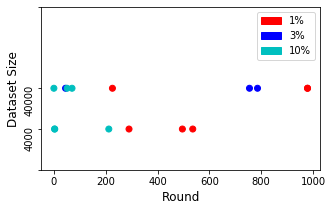

In [28]:
plt.scatter(index_less_than_nb_list,size_list,color=color_list) # index_less_than_nb_list    acc_drop_list  
plt.xlabel('Round',fontsize=12) #Accuracy -collapse           Round
plt.ylabel('Dataset Size',fontsize=12) 
plt.yticks([0,1,2,4],['','4000','40000',''],rotation=90)

# plt.scatter(index_less_than_nb_list,iid_list,color=color_list) # index_less_than_nb_list    acc_drop_list 
# plt.xlabel('Round',fontsize=12)  #Accuracy -collapse            Round
# # plt.ylabel('IID level',fontsize=12) 
# plt.yticks([0,1,2,3,5],['','2c','5c','iid',''],rotation=0)


plt.gcf().set_size_inches(5, 3)
# black_patch = mpatches.Patch(color='k', label='0%')
red_patch = mpatches.Patch(color='r', label='1%')
b_patch = mpatches.Patch(color='b', label='3%')
c_patch = mpatches.Patch(color='c', label='10%')
plt.legend(handles=[red_patch,b_patch,c_patch])

In [29]:
len(index_less_than_nb_list)

15

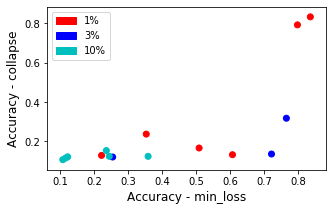

In [31]:
# plt.scatter(acc_at_min_loss_list,index_less_than_nb_list,color=color_list)
plt.scatter(acc_at_min_loss_list,acc_drop_list,color=color_list)
plt.gcf().set_size_inches(5, 3)

plt.xlabel('Accuracy - min_loss',fontsize=12)  
# plt.ylabel('Global Rounds',fontsize=12) 
plt.ylabel('Accuracy - collapse',fontsize=12) 

red_patch = mpatches.Patch(color='r', label='1%')
b_patch = mpatches.Patch(color='b', label='3%')
c_patch = mpatches.Patch(color='c', label='10%')
plt.legend(handles=[red_patch,b_patch,c_patch])

# plt.legend()


In [18]:
from scipy import stats

# apply statistal tests to show if there's a difference between means of the 3 groups
# https://blog.csdn.net/m0_37777649/article/details/74938120

## Data Dispersion

In [19]:
half_window = 10

index_min_loss_list = []
min_loss_list = []
acc_at_min_loss_list = []

color_list = [
    'r','b','r','b','r','b',
    'r','b','r','b','r','b',
]


basedir=os.path.join('RESULT_4000/DataDispersion')
result=[
    '2c.10w.4000.loc1.earlystop500.20200501-072809.npy',
    '2c.40w.4000.loc1.earlystop500.20200507-172304.npy',
    '5c.10w.4000.loc1.earlystop500.20200501-024326.npy',
    '5c.40w.4000.loc1.earlystop500.20200506-215910.npy',
    'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',
    'iid.40w.4000.loc1.earlystop500.20200507-014322.npy',
]
for res in result:
    s1 = np.load(os.path.join(basedir,res))
    (s_acc,_)=windowed(s1[2][:1000],half_window)
    (s_loss,_)=windowed(s1[1][:1000],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    
    min_loss = s_loss[index_min_loss]
    
    acc_at_min_loss = s_acc[index_min_loss]
    
    index_min_loss_list.append(index_min_loss)
    min_loss_list.append(min_loss)
    acc_at_min_loss_list.append(acc_at_min_loss) # Try with it's original&iid min_at_loss???

basedir=os.path.join('RESULT_40000/DataDispersion')    
result=[
    '2c.10w.40000.loc1.earlystop1000.20200521-163612.npy',
    '2c.40w.40000.loc1.earlystop1000.20200522-110021.npy',
    
    '5c.10w.40000.loc1.earlystop1000.20200521-171047.npy',
    '5c.40w.40000.loc1.earlystop1000.20200522-110113.npy',
    
    'iid.10w.40000.loc1.earlystop1000.20200521-172951.npy',
    'iid.40w.40000.loc1.earlystop1000.20200522-105548.npy',
]
for res in result:
    s1 = np.load(os.path.join(basedir,res))
    (s_acc,_)=windowed(s1[2][:1000],half_window)
    (s_loss,_)=windowed(s1[1][:1000],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    
    min_loss = s_loss[index_min_loss]
    
    acc_at_min_loss = s_acc[index_min_loss]
    
    index_min_loss_list.append(index_min_loss)
    min_loss_list.append(min_loss)
    acc_at_min_loss_list.append(acc_at_min_loss) # Try with it's original&iid min_at_loss???

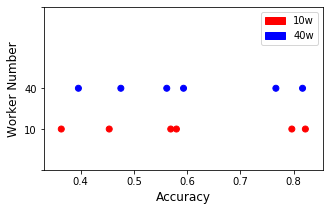

In [20]:
mylist = [
    1,2,1,2,1,2,1,2,1,2,1,2,
]
# plt.scatter(index_min_loss_list,mylist, color=color_list)
plt.scatter(acc_at_min_loss_list,mylist, color=color_list)

plt.gcf().set_size_inches(5, 3)


# plt.xlabel('Round',fontsize=12) 
plt.xlabel('Accuracy',fontsize=12)  
 
plt.ylabel('Worker Number',fontsize=12) 
plt.yticks([0,1,2,4],['','10','40',''],rotation=0)

red_patch = mpatches.Patch(color='r', label='10w')
b_patch = mpatches.Patch(color='b', label='40w')

plt.legend(handles=[red_patch,b_patch])

# plt.legend()

In [21]:
ten_w = []
forty_w = []

for i in range(len(mylist)):
    if mylist[i]==1:
        ten_w.append(index_min_loss_list[i]) # index_min_loss_list  acc_at_min_loss_list
    if mylist[i]==2:
        forty_w.append(index_min_loss_list[i]) # index_min_loss_list  acc_at_min_loss_list
        

In [22]:
stats.levene(ten_w, forty_w) # if p>>0.05, equal_var=true (default) 方差齐次性

LeveneResult(statistic=3.6920203850290174, pvalue=0.08360651432056798)

In [23]:
stats.ttest_rel(ten_w, forty_w) #paired t test, used this!!!!

# stats.ttest_ind(ten_w, forty_w)
# stats.f_oneway(ten_w, forty_w) #ANOVA

Ttest_relResult(statistic=-4.582034112527078, pvalue=0.00593646963137399)

In [24]:
stats.ttest_ind(ten_w, forty_w,equal_var=False)

Ttest_indResult(statistic=-2.714776170395291, pvalue=0.032170545953306165)

## Delayed Update